In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
from scipy.stats.distributions import chi2
import warnings
warnings.filterwarnings('ignore')
from arch import arch_model
from pmdarima.arima import auto_arima

In [2]:
raw_data = yf.download(tickers = '^NSEI ^SPX', start = '2010-01-01', end = dt.datetime.now(),interval = '1d', group_by = 'ticker',auto_adjust = True, treads = True)
raw_data.head()
df = raw_data.copy()
df['nifty'] = raw_data['^NSEI'].Close[:]
df['spx'] = raw_data['^SPX'].Close[:]
del df['^NSEI']
del df['^SPX']
df['nifty'].fillna(method = 'ffill',inplace = True)
df['spx'].fillna(method = 'ffill',inplace = True)

[*********************100%***********************]  2 of 2 completed


Text(0.5, 1.0, 'Historical Returns')

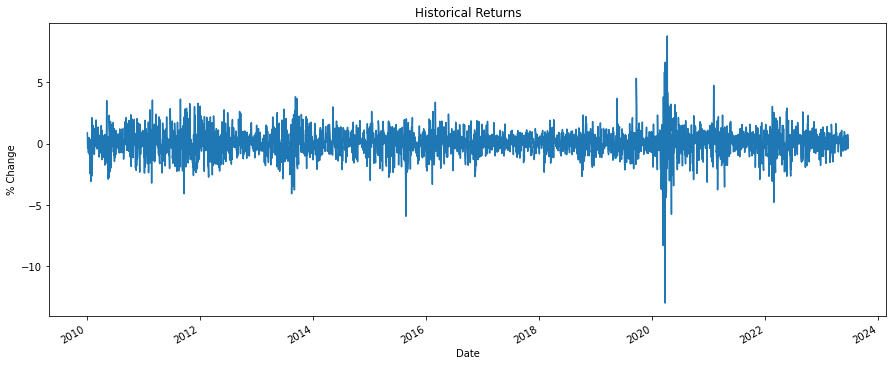

In [3]:
df['Returns'] = df.nifty.pct_change(1)*100
df['Sq Returns'] = df['Returns'].mul(df['Returns'])
df['Returns'][1:].plot(figsize = (15,6))
plt.ylabel('% Change')
plt.title('Historical Returns')

Text(0.5, 1.0, 'Volatility')

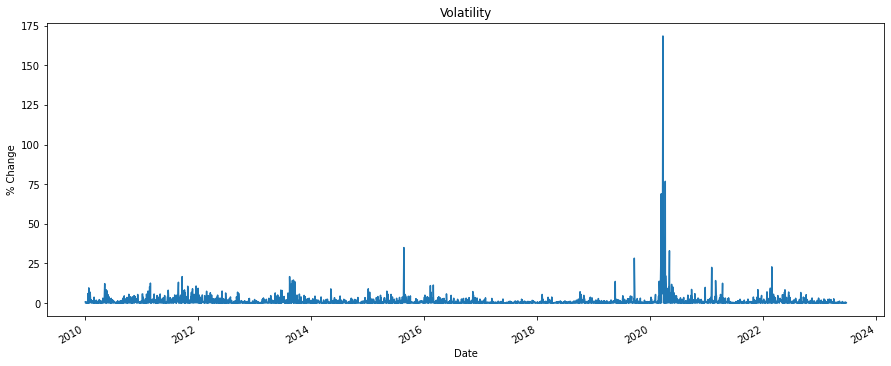

In [4]:
df['Sq Returns'][1:].plot(figsize = (15,6))
plt.ylabel('% Change')
plt.title('Volatility')

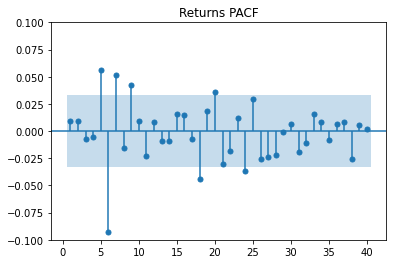

In [5]:
sgt.plot_pacf(df['Returns'][1:],zero = False,lags = 40)
plt.title("Returns PACF")
plt.ylim(-0.1,0.1)
plt.show()

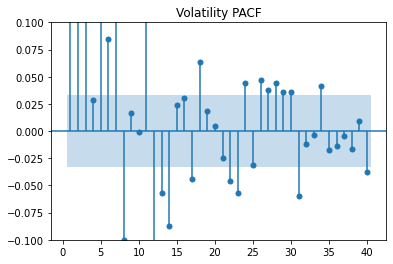

In [6]:
sgt.plot_pacf(df['Sq Returns'][1:],zero = False,lags = 40)
plt.title("Volatility PACF")
plt.ylim(-0.1,0.1)
plt.show()

# AUTO ARIMA


In [7]:
model_arima = auto_arima(df['Returns'][1:])

In [8]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3475
Model:               SARIMAX(3, 0, 4)   Log Likelihood               -5089.878
Date:                Tue, 20 Jun 2023   AIC                          10197.755
Time:                        19:17:05   BIC                          10253.135
Sample:                             0   HQIC                         10217.527
                               - 3475                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2318      0.107      2.157      0.031       0.021       0.442
ar.L1         -2.1274      0.126    -16.820      0.000      -2.375      -1.880
ar.L2         -1.7895      0.200     -8.943      0.000      -2.182      -1.397
ar.L3         -0.5469      0.107     -5.100      0.000      -0.757      -0.337
ma.L1          2.1507      0.129     16.711      0.000       1.898       2.403
ma.L2          1.8426      0.211      8.744      0.000       1.430       2.256
ma.L3          0.5904      0.128      4.603      0.000       0.339       0.842
ma.L4         -0.0109      0.020     -0.534      0.594      -0.051       0.029
sigma2         1.0956      0.013     84.349      0.000       1.070       1.121
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             16289.51
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
model_auto = auto_arima(df['nifty'][2500:],exogeneous =df['spx'][2500:], m =5, max_order = None, max_p = 7,max_q = 7, max_d = 2, max_P = 4,max_Q = 4, max_D = 2, maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'aic', out_of_sample_size = int(len(df)*0.2))

In [11]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  976
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 5)   Log Likelihood               -6340.201
Date:                           Tue, 20 Jun 2023   AIC                          12688.402
Time:                                   19:20:45   BIC                          12707.932
Sample:                                        0   HQIC                         12695.834
                                           - 976                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.9553     10.569      0.658      0.510     -13.760      27.671
drift          0.0002      0.020      0.008      0.994      -0.038       0.039
ar.S.L5        0.1127      0.023      4.974      0.000       0.068       0.157
sigma2      2.608e+04    733.702     35.541      0.000    2.46e+04    2.75e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               954.35
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""